In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets ,models , transforms
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path

In [3]:
csv_path = 'e:/mlprojectdata/samples/sample2/'

train_csv = pd.read_csv(csv_path + 'random_trainset.csv')
val_csv = pd.read_csv(csv_path + 'random_testset.csv')
train_csv.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,4283deac-bba4-11e8-b2b9-ac1f6b6435d0,2 0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3eff8436-bbb6-11e8-b2ba-ac1f6b6435d0,25 6 3,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,07a298f8-bba6-11e8-b2ba-ac1f6b6435d0,14 5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,cc82a39c-bba2-11e8-b2b9-ac1f6b6435d0,25 6,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,fcc35f9a-bb9a-11e8-b2b9-ac1f6b6435d0,4,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
class ImgDataset(Dataset):

    def __init__(self,frames, root_dir, transform=None, labels = 28):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frames = frames
        self.root_dir = root_dir
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.frames.iloc[idx, 0]+'.png')
        #image = open_rgby(img_name)
        #image = load_image(self.frames.iloc[idx, 0],self.root_dir)
        img = Image.open(img_name)
        label=  torch.tensor(self.frames.iloc[idx, 2:(2+self.labels)].tolist(), dtype=torch.float32)

        if self.transform:
            #temp_img = Image.open(sample['image'])
            img = self.transform(img)
            
        sample = {'image': img, 'label': label}
        return sample

In [4]:
transformer = transforms.Compose([transforms.Resize((224,224)) , 
                               transforms.ToTensor(),
                               transforms.Normalize([0.5,], [0.5,])
                               ])
data_path = 'e:/mlprojectdata/'

train_dataset = ImgDataset(frames=train_csv,
                           root_dir=data_path+'updated_train/', transform=transformer, labels = 28)
val_dataset = ImgDataset(frames=val_csv,
                           root_dir=data_path+'updated_train/', transform=transformer, labels = 28)

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,num_workers=0)


In [5]:
import time
import seaborn as sns
import os
from sklearn.metrics import precision_score,f1_score

In [6]:
model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)
## freeze the entire convolution base
for param in model.parameters():
      param.requires_grad_(False)

2048


In [7]:
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
    features_lst = [num_features , num_features//2 , num_features//4]
    layers = []
    for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
        layers.append(nn.Linear(in_f , out_f))
        layers.append(activation_func())
        layers.append(nn.BatchNorm1d(out_f))
        if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
    layers.append(nn.Linear(features_lst[-1] , number_classes))
    return nn.Sequential(*layers)

top_head = create_head(num_features , 28) # because ten classes
model.fc = top_head # replace the fully connected layer

In [8]:
w = model.conv1.weight
model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#model.conv1.weight = nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))

In [14]:
model

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [10]:
threshold = 0.5

In [11]:
def TP_FP_FP_TN(actual, pred):
    
    TP=np.zeros((1,actual.shape[1]),dtype=int)
    FP=np.zeros((1,actual.shape[1]),dtype=int)
    TN=np.zeros((1,actual.shape[1]),dtype=int)
    FN=np.zeros((1,actual.shape[1]),dtype=int)
    
    for c in range(actual.shape[1]):
        TP_cnt = 0
        FP_cnt= 0
        FN_cnt = 0
        TN_cnt = 0

        for i in range(actual.shape[0]): 
            if actual[i,c]==1 and pred[i,c]==1:
                TP_cnt += 1
            if actual[i,c]==0 and pred[i,c]==1:
                FP_cnt += 1
            if actual[i,c]==1 and pred[i,c]==0:
                FN_cnt += 1
            if actual[i,c]==0 and pred[i,c]==0:
                TN_cnt += 1               
               
        TP[0,c]=TP_cnt
        FP[0,c]=FP_cnt
        FN[0,c]=FN_cnt
        TN[0,c]=TN_cnt        

    return TP, TN, FP, FN

def Macro_F1_score(TP, TN, FP, FN, beta=2):
    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    F1 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    F1_score=np.mean(F1)
    return F1_score

def Micro_F1_score(TP, TN, FP, FN, beta=2):
    TP=TP.sum(axis=1)
    TN=TN.sum(axis=1)
    FP=FP.sum(axis=1)
    FN=FN.sum(axis=1)
    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    #print(precision, recall)
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2[0]

def Accuracy(TP, TN, FP, FN):
    TP=TP.sum(axis=1)
    TN=TN.sum(axis=1)
    FP=FP.sum(axis=1)
    FN=FN.sum(axis=1)
    acc=(TP+TN)/(TP+TN+FP+FN+ 1e-12)
    return acc[0]

In [12]:
def fit_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epoch_nums):
    probablity = []
    loss_history = [[],[]]
    for epoch in range(epoch_nums):
        print("Epoch: {}".format(epoch))
        start_t = time.time()
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader
                
            run_loss,running_TP,running_TN,running_FP,running_FN,batch_num = 0,0,0,0,0,0
            
            for i, data in enumerate(data_loader):
                if i %50 == 0:
                    print('batch: '+str(i)+' processing...')
                x, target = data['image'], data['label'].float()
                
                with torch.set_grad_enabled(phase=="train"):
                    out = model(x)
                    loss = criterion(out,target)
                    out_p = torch.sigmoid(out).data
                    preds = out_p > threshold
                    preds = preds.to(torch.float32)
                    
                    if phase=="train"  :
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                        scheduler.step()
                        
                    else:
                        if epoch+1 == epoch_nums:
                            out_p = out_p.detach().numpy() 
                            for n in range(out_p.shape[0]):
                                probablity.append(out_p[n])
                                
                run_loss+=loss.item()*x.size(0)
                if i %10 == 0:
                    if phase =='train':
                        loss_history[0].append(run_loss/(i+1)/batch_size)
                    else:
                        loss_history[1].append(run_loss/(i+1)/batch_size)
                        
                yactual=target.to(torch.int).numpy()
                ypred=preds.to(torch.int).numpy()
                run_TP, run_TN, run_FP, run_FN=TP_FP_FP_TN(yactual,ypred)
                running_TP+=run_TP
                running_TN+=run_TN
                running_FP+=run_FP
                running_FN+=run_FN
                batch_num+= 1
            data_size = len(data_loader.dataset)
            total_batch_loss = run_loss/data_size
            total_batch_acc=Accuracy(running_TP, running_TN, running_FP, running_FN)
            total_batch_f1=Micro_F1_score(running_TP, running_TN, running_FP, running_FN)
            total_batch_macrof1=Macro_F1_score(running_TP, running_TN, running_FP, running_FN)
            
            
            print("{} loss is {} ".format(phase,total_batch_loss))
            print("{} f1-score is {} ".format(phase, total_batch_f1))
            print("{} macro f1-score is {} ".format(phase, total_batch_macrof1))    
            print("{} accuracy is {} ".format(phase, total_batch_acc))  
        
        print('epoch '+str(epoch)+' cost:'+ str(time.time()-start_t))

    return pd.DataFrame(probablity),loss_history

In [22]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

In [31]:
p = fit_model(model,train_loader, validation_loader, criterion, optimizer,sgdr_partial,epoch_nums=3)

Epoch: 0
batch 0 processing...
batch 50 processing...
batch 100 processing...
batch 150 processing...
train loss is 0.18324552646751435 
train f1-score is 0.2223954688026544 
train macro f1-score is 0.04247334961106307 
train accuracy is 0.9429776810016336 
batch 0 processing...
batch 50 processing...
val loss is 0.17186575004435756 
val f1-score is 0.1367427444350521 
val macro f1-score is 0.02265591638048617 
val accuracy is 0.9461870547035383 
epoch 0 cost:1714.0190539360046
Epoch: 1
batch 0 processing...
batch 50 processing...
batch 100 processing...
batch 150 processing...
train loss is 0.1758321973918852 
train f1-score is 0.2387005210358505 
train macro f1-score is 0.04626499448890099 
train accuracy is 0.9448440780776106 
batch 0 processing...
batch 50 processing...
val loss is 0.177873554478131 
val f1-score is 0.14957533309181661 
val macro f1-score is 0.034630402693708845 
val accuracy is 0.943666223886004 
epoch 1 cost:1853.1220688819885
Epoch: 2
batch 0 processing...
batch

In [37]:
p.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.363160,0.022471,0.077042,0.077864,0.031411,0.041686,0.060321,0.114455,0.006332,0.003314,...,0.019531,0.070680,0.004185,0.060918,0.017953,0.101440,0.007789,0.357570,0.003589,0.000457
1,0.859158,0.014680,0.095128,0.019054,0.033135,0.071934,0.014728,0.051664,0.000457,0.000209,...,0.011043,0.026141,0.001446,0.087511,0.008686,0.074681,0.000812,0.380767,0.002936,0.000185
2,0.421687,0.013552,0.070976,0.028730,0.033846,0.050277,0.041651,0.080380,0.001299,0.001086,...,0.013819,0.055735,0.001019,0.079993,0.007958,0.067618,0.002957,0.537927,0.002469,0.000147
3,0.479917,0.034954,0.095917,0.127937,0.034877,0.085293,0.041524,0.135773,0.007894,0.011732,...,0.009823,0.049812,0.009269,0.065966,0.042659,0.067143,0.009681,0.136639,0.007922,0.001138
4,0.936626,0.061480,0.158108,0.029675,0.078213,0.083685,0.002628,0.182321,0.000427,0.000234,...,0.012084,0.043910,0.000616,0.021075,0.012488,0.032361,0.001267,0.116719,0.003750,0.000555


In [44]:
import math
def proba_plots(p,plot_num,fig_size = (20,10)):
    rows= math.ceil(plot_num/2)
    print(rows)
    fig, ax = plt.subplots(rows,2,figsize=fig_size)
    for r in range(rows):
        proba_predictions0 = p.iloc[:,2*r].values
        proba_predictions1 = p.iloc[:,2*r+1].values
        sns.distplot(proba_predictions0.flatten() * 100, color="DodgerBlue", ax=ax[r][0])
        sns.distplot(proba_predictions1.flatten() * 100, color="DodgerBlue", ax=ax[r][1])
        ax[r][0].set_xlabel("Probability in Class "+str(2*r))
        ax[r][0].set_ylabel("Density")
        ax[r][1].set_xlabel("Probability in Class "+str(2*r+1))
        ax[r][1].set_ylabel("Density")

Text(0, 0.5, 'Density')

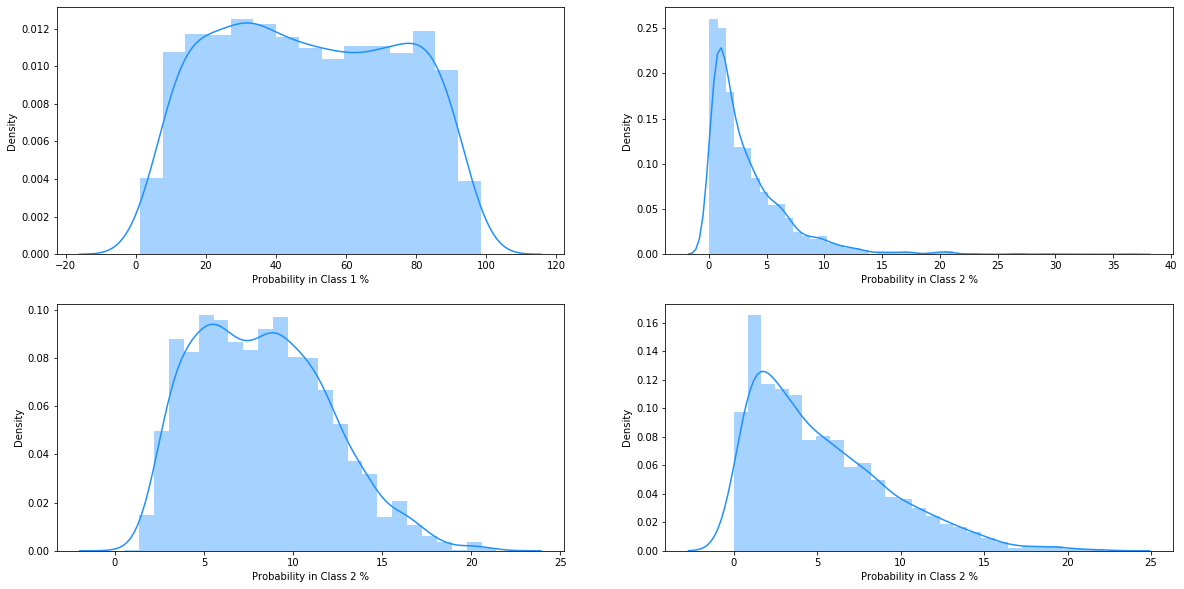

In [41]:
proba_predictions0 = p.iloc[:,0].values
proba_predictions1 = p.iloc[:,1].values
proba_predictions2 = p.iloc[:,2].values
proba_predictions3 = p.iloc[:,3].values
fig, ax = plt.subplots(2,2,figsize=(20,10))
sns.distplot(proba_predictions0.flatten() * 100, color="DodgerBlue", ax=ax[0][0])
ax[0][0].set_xlabel("Probability in Class 1 %")
ax[0][0].set_ylabel("Density")
sns.distplot(proba_predictions1.flatten() * 100, color="DodgerBlue", ax=ax[0][1])
ax[0][1].set_xlabel("Probability in Class 2 %")
ax[0][1].set_ylabel("Density")
sns.distplot(proba_predictions2.flatten() * 100, color="DodgerBlue", ax=ax[1][0])
ax[1][0].set_xlabel("Probability in Class 3 %")
ax[1][0].set_ylabel("Density")
sns.distplot(proba_predictions3.flatten() * 100, color="DodgerBlue", ax=ax[1][1])
ax[1][1].set_xlabel("Probability in Class 2 %")
ax[1][1].set_ylabel("Density")

In [23]:
def createCheckpoint(save_path='e:/mlprojectdata/saved_models/', filename = 'LatestCheckpoint.pt'):
    checkpoint = {
              'epoch': 5,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,
            } # save all important stuff
    torch.save(checkpoint , Path(save_path+filename))

In [35]:
createCheckpoint(filename='ResNet50_BCE')

In [46]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [47]:
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

In [48]:
p,train_loss = fit_model(model,train_loader, validation_loader, criterion, optimizer,sgdr_partial,epoch_nums=3)

Epoch: 0
batch: 0 processing...


E:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


batch: 50 processing...
batch: 100 processing...
batch: 150 processing...
train loss is 2.6802849145749805 
train f1-score is 0.17027408840751893 
train macro f1-score is 0.05828078652133005 
train accuracy is 0.8633123363662285 
batch: 0 processing...
batch: 50 processing...
val loss is 1.43863268998953 
val f1-score is 0.1511411665257819 
val macro f1-score is 0.03491801197449188 
val accuracy is 0.9434850863422294 
epoch 0 cost:1841.641365289688
Epoch: 1
batch: 0 processing...
batch: 50 processing...
batch: 100 processing...
batch: 150 processing...
train loss is 1.6658274919319187 
train f1-score is 0.20863339970580036 
train macro f1-score is 0.05050346324643548 
train accuracy is 0.9333799932602327 
batch: 0 processing...
batch: 50 processing...
val loss is 1.8203951676619425 
val f1-score is 0.13539025077486613 
val macro f1-score is 0.03331865491408468 
val accuracy is 0.9412510566356719 
epoch 1 cost:1738.7831037044525
Epoch: 2
batch: 0 processing...
batch: 50 processing...
ba

Text(0, 0.5, 'Density')

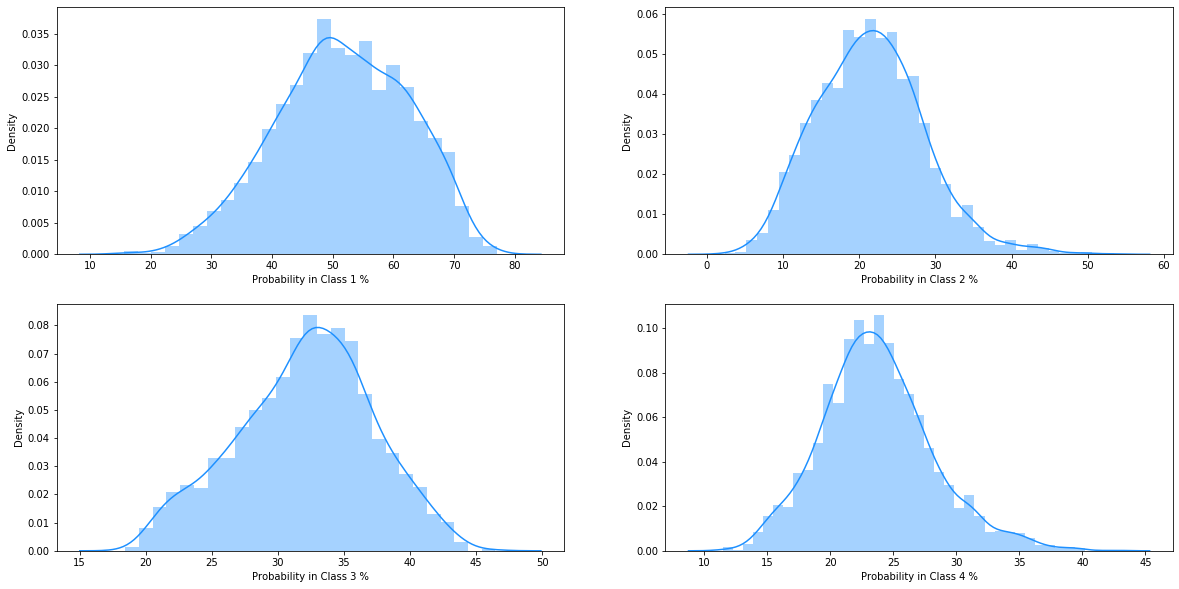

In [49]:
proba_predictions0 = p.iloc[:,0].values
proba_predictions1 = p.iloc[:,1].values
proba_predictions2 = p.iloc[:,2].values
proba_predictions3 = p.iloc[:,3].values
fig, ax = plt.subplots(2,2,figsize=(20,10))
sns.distplot(proba_predictions0.flatten() * 100, color="DodgerBlue", ax=ax[0][0])
ax[0][0].set_xlabel("Probability in Class 1 %")
ax[0][0].set_ylabel("Density")
sns.distplot(proba_predictions1.flatten() * 100, color="DodgerBlue", ax=ax[0][1])
ax[0][1].set_xlabel("Probability in Class 2 %")
ax[0][1].set_ylabel("Density")
sns.distplot(proba_predictions2.flatten() * 100, color="DodgerBlue", ax=ax[1][0])
ax[1][0].set_xlabel("Probability in Class 3 %")
ax[1][0].set_ylabel("Density")
sns.distplot(proba_predictions3.flatten() * 100, color="DodgerBlue", ax=ax[1][1])
ax[1][1].set_xlabel("Probability in Class 4 %")
ax[1][1].set_ylabel("Density")

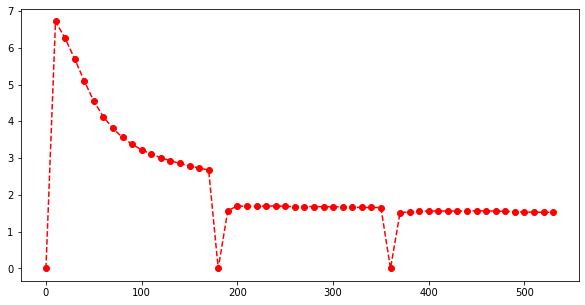

In [51]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(np.arange(len(train_loss))*10, train_loss, 'r--o', label="train_loss")

In [52]:
createCheckpoint(filename='ResNet50_Focal_0.pt')

In [14]:
class FocalLoss2(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss2, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [69]:
criterion = FocalLoss2(logits = True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

In [70]:
p,loss = fit_model(model,train_loader, validation_loader, criterion, optimizer,sgdr_partial,epoch_nums=3)

Epoch: 0
batch: 0 processing...


E:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


batch: 50 processing...
batch: 100 processing...
batch: 150 processing...
train loss is 0.09408456615994142 
train f1-score is 0.16100597212879153 
train macro f1-score is 0.054281849798296 
train accuracy is 0.8681533037820461 
batch: 0 processing...
batch: 50 processing...
val loss is 0.05299706561199609 
val f1-score is 0.1882944893933904 
val macro f1-score is 0.03864181124062252 
val accuracy is 0.9421567443545464 
epoch 0 cost:2002.5848319530487
Epoch: 1
batch: 0 processing...
batch: 50 processing...
batch: 100 processing...
batch: 150 processing...
train loss is 0.0606337225838963 
train f1-score is 0.19951901663932148 
train macro f1-score is 0.04623454106720576 
train accuracy is 0.934390958343054 
batch: 0 processing...
batch: 50 processing...
val loss is 0.07063477555650427 
val f1-score is 0.2623978585517047 
val macro f1-score is 0.022208173154190016 
val accuracy is 0.9379000120758362 
epoch 1 cost:1956.0103495121002
Epoch: 2
batch: 0 processing...
batch: 50 processing...

Text(0, 0.5, 'Density')

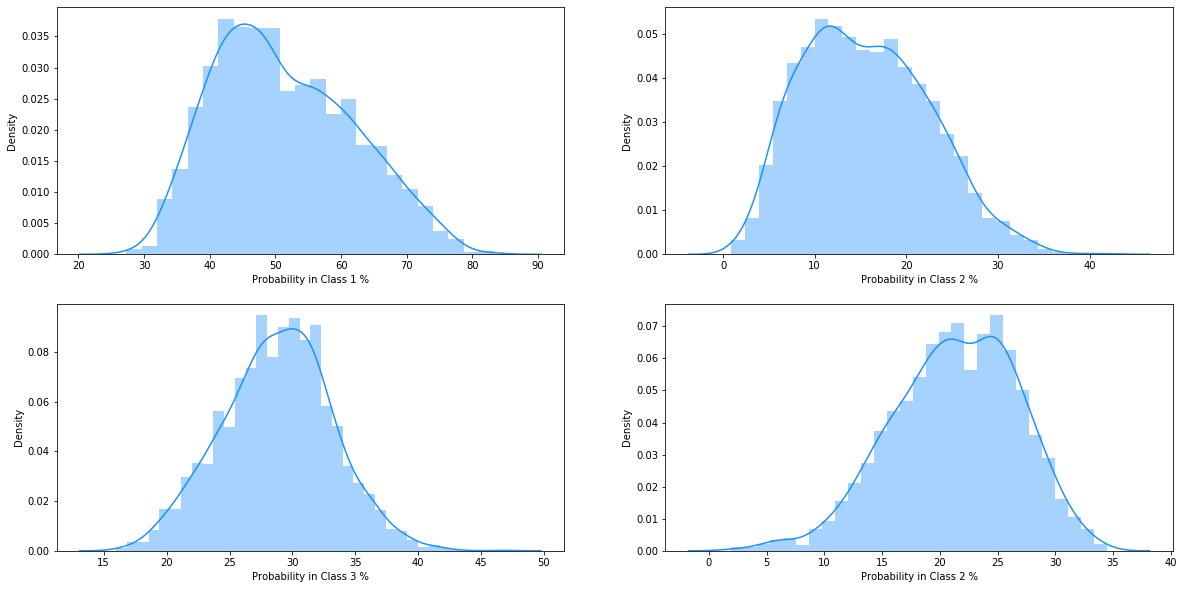

In [71]:
proba_predictions0 = p.iloc[:,0].values
proba_predictions1 = p.iloc[:,1].values
proba_predictions2 = p.iloc[:,2].values
proba_predictions3 = p.iloc[:,3].values
fig, ax = plt.subplots(2,2,figsize=(20,10))
sns.distplot(proba_predictions0.flatten() * 100, color="DodgerBlue", ax=ax[0][0])
ax[0][0].set_xlabel("Probability in Class 1 %")
ax[0][0].set_ylabel("Density")
sns.distplot(proba_predictions1.flatten() * 100, color="DodgerBlue", ax=ax[0][1])
ax[0][1].set_xlabel("Probability in Class 2 %")
ax[0][1].set_ylabel("Density")
sns.distplot(proba_predictions2.flatten() * 100, color="DodgerBlue", ax=ax[1][0])
ax[1][0].set_xlabel("Probability in Class 3 %")
ax[1][0].set_ylabel("Density")
sns.distplot(proba_predictions3.flatten() * 100, color="DodgerBlue", ax=ax[1][1])
ax[1][1].set_xlabel("Probability in Class 2 %")
ax[1][1].set_ylabel("Density")

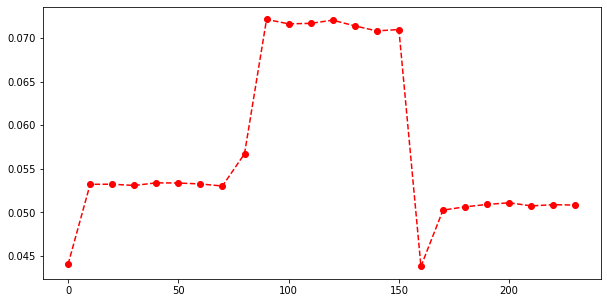

In [74]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(np.arange(len(loss[1]))*10, loss[1], 'r--o', label="train_loss")

In [75]:
createCheckpoint(filename='ResNet50_Focal_1.pt')

In [15]:
criterion = FocalLoss2(logits = True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

In [16]:
p,loss = fit_model(model,train_loader, validation_loader, criterion, optimizer,sgdr_partial,epoch_nums=3)

Epoch: 0
batch: 0 processing...


E:\anaconda\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


batch: 50 processing...
batch: 100 processing...
batch: 150 processing...
train loss is 0.09642956977616506 
train f1-score is 0.20703036696529598 
train macro f1-score is 0.08845198724231448 
train accuracy is 0.8621523187391451 
batch: 0 processing...
batch: 50 processing...
val loss is 0.051108417476724996 
val f1-score is 0.2273405334446208 
val macro f1-score is 0.031158279696287677 
val accuracy is 0.9439681197922957 
epoch 0 cost:1634.4776694774628
Epoch: 1
batch: 0 processing...
batch: 50 processing...
batch: 100 processing...
batch: 150 processing...
train loss is 0.06151977580394227 
train f1-score is 0.23935217256274527 
train macro f1-score is 0.06149553679125335 
train accuracy is 0.932356067086606 
batch: 0 processing...
batch: 50 processing...
val loss is 0.05309967611328284 
val f1-score is 0.17407769362318695 
val macro f1-score is 0.027567927679362312 
val accuracy is 0.9440134041782393 
epoch 1 cost:1654.2511849403381
Epoch: 2
batch: 0 processing...
batch: 50 process

In [18]:
p,loss = fit_model(model,train_loader, validation_loader, criterion, optimizer,sgdr_partial,epoch_nums=3)

Epoch: 0
batch: 0 processing...


E:\anaconda\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


batch: 50 processing...
batch: 100 processing...
batch: 150 processing...
train loss is 0.05179161264494702 
train f1-score is 0.24988334684042648 
train macro f1-score is 0.05503481897808845 
train accuracy is 0.9401716048422635 
batch: 0 processing...
batch: 50 processing...
val loss is 0.04739263619430873 
val f1-score is 0.19276303806682707 
val macro f1-score is 0.03562646115041963 
val accuracy is 0.9444813428329912 
epoch 0 cost:1682.2049555778503
Epoch: 1
batch: 0 processing...
batch: 50 processing...
batch: 100 processing...
batch: 150 processing...
train loss is 0.04918481317752504 
train f1-score is 0.2622364689926148 
train macro f1-score is 0.06167565697031404 
train accuracy is 0.9424268346424035 
batch: 0 processing...
batch: 50 processing...
val loss is 0.04685919949137751 
val f1-score is 0.2837173488123124 
val macro f1-score is 0.04592426400232032 
val accuracy is 0.9480135249366018 
epoch 1 cost:1671.651159286499
Epoch: 2
batch: 0 processing...
batch: 50 processing.

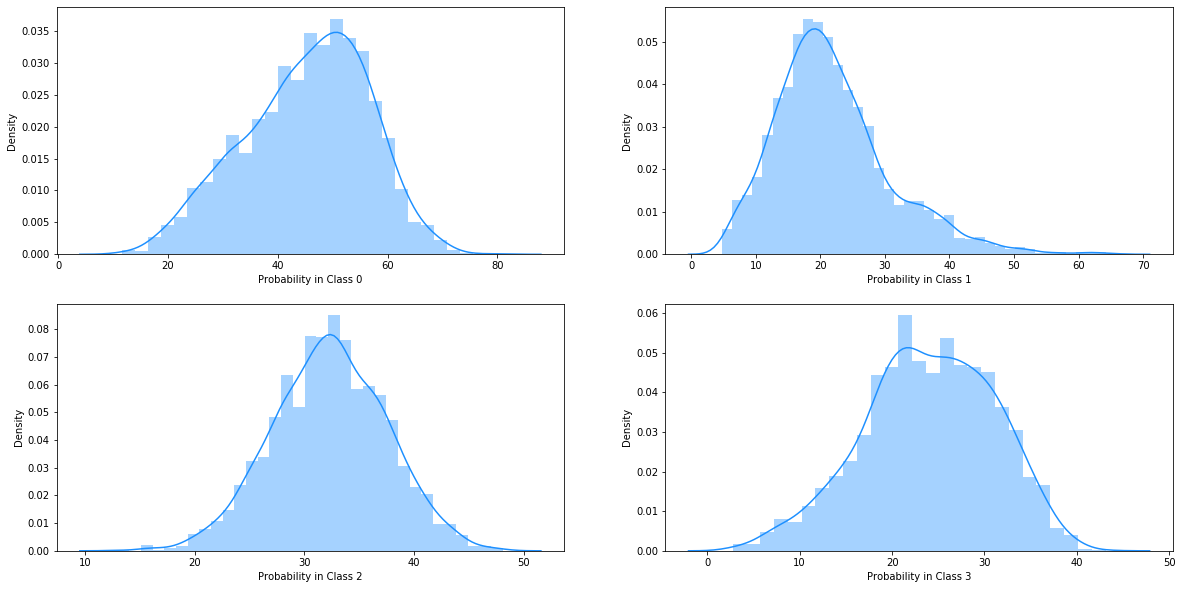

In [19]:
proba_plots(p,4)

In [24]:
createCheckpoint(filename='ResNet50_Focal_1_1.pt')

In [20]:
csv0_path = 'e:/mlprojectdata/samples/sample3/'

train0_csv = pd.read_csv(csv0_path + 'random_trainset.csv')
val0_csv = pd.read_csv(csv0_path + 'random_testset.csv')
train0_csv.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,e471c4f6-bbb6-11e8-b2ba-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0b517ef0-bb9d-11e8-b2b9-ac1f6b6435d0,12 25 0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,c66c1032-bbbc-11e8-b2ba-ac1f6b6435d0,25 0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,7c0d643a-bba5-11e8-b2ba-ac1f6b6435d0,5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,95ed3c70-bbbb-11e8-b2ba-ac1f6b6435d0,22 0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [21]:
transformer = transforms.Compose([transforms.Resize((224,224)) , 
                               transforms.ToTensor(),
                               transforms.Normalize([0.5,], [0.5,])
                               ])
data_path = 'e:/mlprojectdata/'

train_dataset = ImgDataset(frames=train0_csv,
                           root_dir=data_path+'updated_train/', transform=transformer, labels = 28)
val_dataset = ImgDataset(frames=val0_csv,
                           root_dir=data_path+'updated_train/', transform=transformer, labels = 28)

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,num_workers=0)


In [25]:
p,loss = fit_model(model,train_loader, validation_loader, criterion, optimizer,sgdr_partial,epoch_nums=3)

Epoch: 0
batch: 0 processing...


E:\anaconda\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


batch: 50 processing...
batch: 100 processing...
batch: 150 processing...
batch: 200 processing...
batch: 250 processing...
batch: 300 processing...
batch: 350 processing...
batch: 400 processing...
batch: 450 processing...
batch: 500 processing...
batch: 550 processing...
batch: 600 processing...
batch: 650 processing...
train loss is 0.04462849974613088 
train f1-score is 0.26880413505446604 
train macro f1-score is 0.05103779953184435 
train accuracy is 0.9464228266792722 
batch: 0 processing...
batch: 50 processing...
batch: 100 processing...
batch: 150 processing...
batch: 200 processing...
batch: 250 processing...
val loss is 0.043862772946987635 
val f1-score is 0.29058862059714746 
val macro f1-score is 0.046326042799084206 
val accuracy is 0.9472936763129689 
epoch 0 cost:8119.246256351471
Epoch: 1
batch: 0 processing...
batch: 50 processing...
batch: 100 processing...
batch: 150 processing...
batch: 200 processing...
batch: 250 processing...
batch: 300 processing...
batch: 35

14


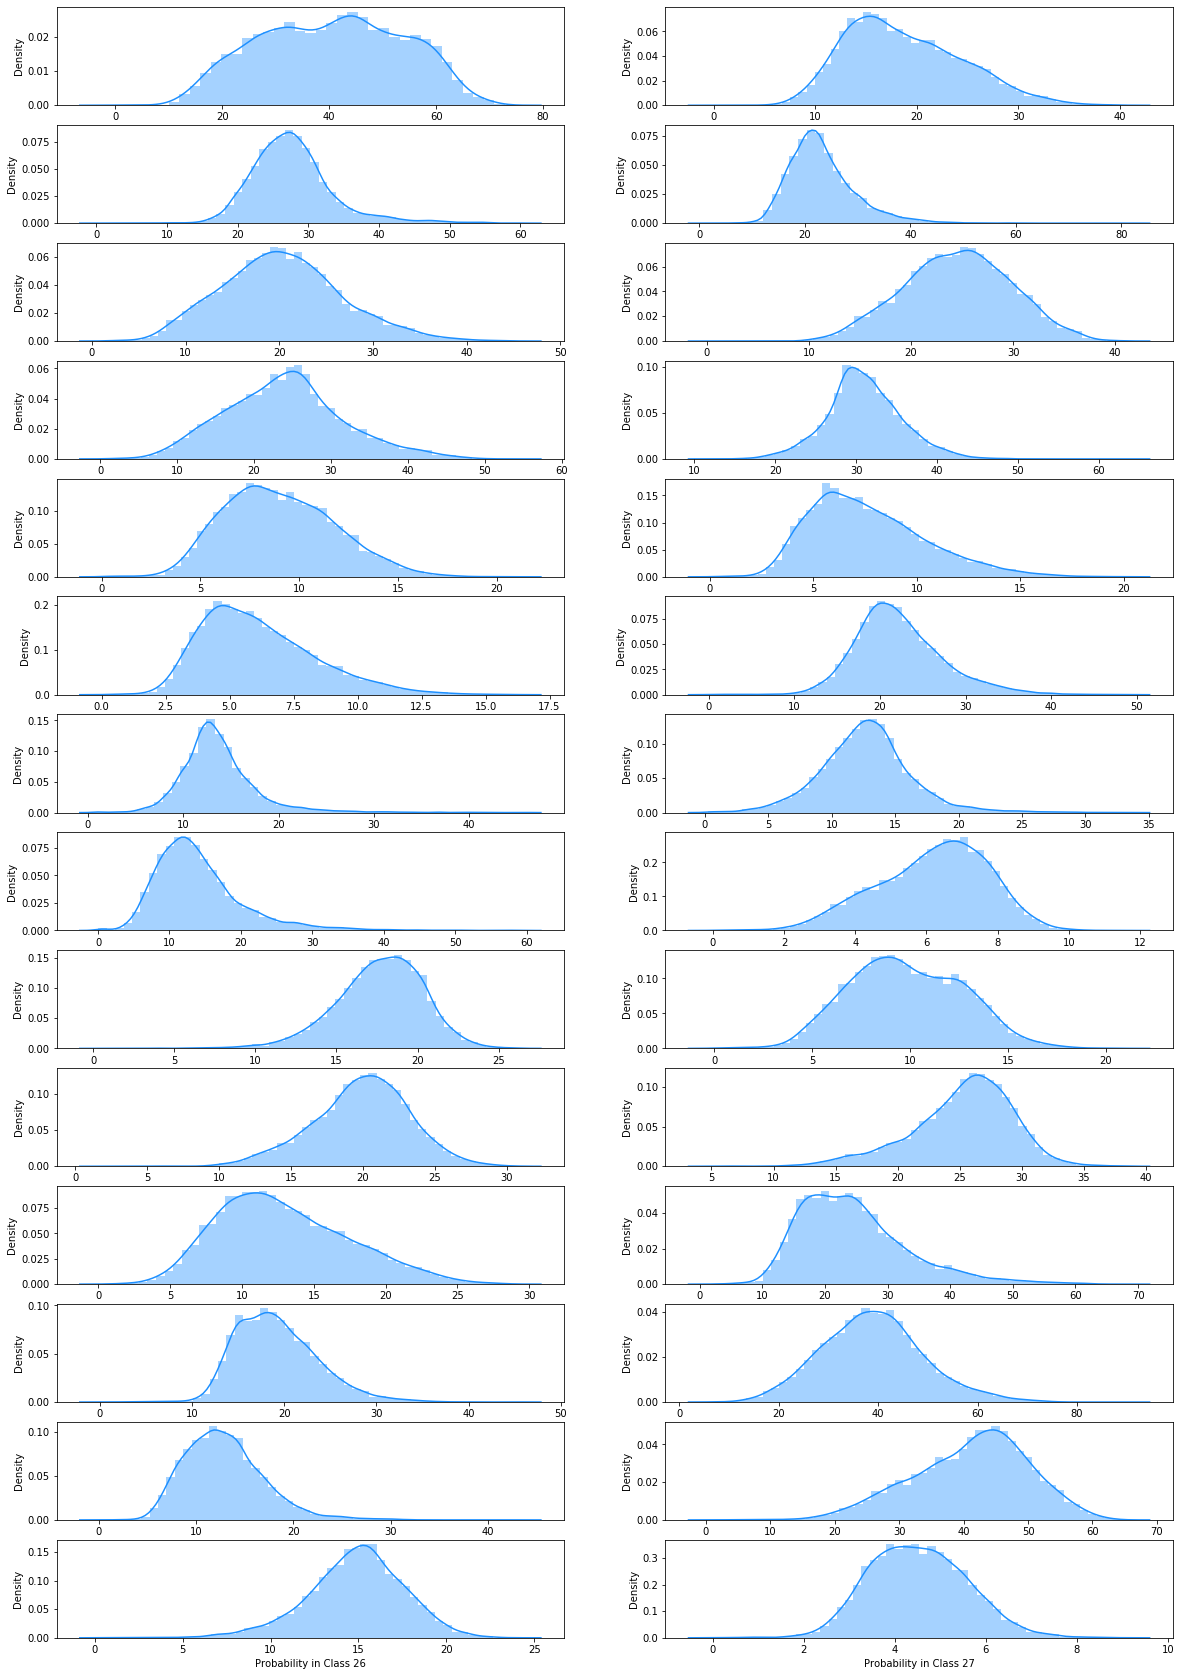

In [43]:
proba_plots(p,28,(20,30))

In [46]:
createCheckpoint(filename='ResNet50_Focal_final.pt')